# SigRelayST Training: Comparing Models With and Without Signature Bias

This notebook trains SigRelayST (Signature-based Relay for Spatial Transcriptomics) to compare models **with** and **without** signature bias.

**Goal**: Determine if the `scaled_bias` from `sigrelay_LR_pair_bias_capped.csv` modifies the final attention scores and yields different results.

**Approach**:
1. Preprocess data **with** signature bias → 4D edge attributes
2. Preprocess data **without** signature bias → 3D edge attributes  
3. Train models on both graphs
4. Compare attention scores to see the impact of signature bias

**Epochs**: Based on CellNEST workflow, 40,000-80,000 epochs are recommended.

SigRelayST extends CellNEST with signature-based bias terms derived from the Lignature database.

## Setup


In [3]:
# Install dependencies
# Required packages for GATv2Conv_SigRelayST and training
%pip install torch torch-geometric torch-sparse torch-scatter scanpy pandas numpy scipy scikit-learn qnorm -q

# Verify GPU and imports
import torch
import torch_geometric
from torch_sparse import SparseTensor

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Geometric version: {torch_geometric.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")


PyTorch version: 2.9.0+cu126
PyTorch Geometric version: 2.7.0
CUDA available: False


In [8]:
!git clone https://github.com/krystennguyen/SigRelayST.git

Cloning into 'SigRelayST'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 67 (delta 4), reused 15 (delta 3), pack-reused 45 (from 2)
Receiving objects: 100% (67/67), 102.22 MiB | 18.33 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [13]:
%cd SigRelayST

/content/SigRelayST


## Verify Files

Check that all required files are present.


In [14]:
import os

required_files = [
    'data/V1_Human_Lymph_Node_spatial/filtered_feature_bc_matrix.h5',
    'database/sigrelay_LR_pair_bias_capped.csv',
    'database/CellNEST_database.csv',
    'data_preprocess_SigRelayST.py',
    'run_SigRelayST.py',
    'CCC_gat.py',
    'GATv2Conv_SigRelayST.py'
]

print("Checking required files...")
print(f"Working directory: {os.getcwd()}\n")

all_present = True
for file in required_files:
    if os.path.exists(file):
        size = os.path.getsize(file) / (1024*1024)  # MB
        print(f"✓ {file} ({size:.2f} MB)")
    else:
        print(f"✗ {file} - MISSING")
        all_present = False

if all_present:
    print("\n✓ All files present! Ready to preprocess and train.")
else:
    print("\n⚠ Some files are missing. Please ensure data files are in the repository or upload them.")


Checking required files...
Working directory: /content/SigRelayST

✓ data/V1_Human_Lymph_Node_spatial/filtered_feature_bc_matrix.h5 (29.31 MB)
✓ database/sigrelay_LR_pair_bias_capped.csv (0.25 MB)
✓ database/CellNEST_database.csv (0.39 MB)
✓ data_preprocess_SigRelayST.py (0.03 MB)
✓ run_SigRelayST.py (0.01 MB)
✓ CCC_gat.py (0.01 MB)
✓ GATv2Conv_SigRelayST.py (0.02 MB)

✓ All files present! Ready to preprocess and train.


/bin/bash: line 1: cd: SigRelayST: No such file or directory


## Step 1: Preprocess Data

We need to preprocess the data **twice**:
1. **With signature bias** → Creates 4D edge attributes (includes scaled_bias)
2. **Without signature bias** → Creates 3D edge attributes (standard CellNEST)


In [20]:
# Preprocess WITH signature bias (4D edges)
# This creates input graph with scaled_bias as 4th dimension

import os
import subprocess

os.makedirs('logs', exist_ok=True)

print("=" * 60)
print("Preprocessing WITH signature bias")
print("=" * 60)
print("This will create 4D edge attributes (includes scaled_bias)")
print("Output: input_graph/V1_Human_Lymph_Node_spatial/")
print()

# Preprocess with signature bias
result = subprocess.run([
    'python', 'data_preprocess_SigRelayST.py',
    '--data_name=V1_Human_Lymph_Node_spatial',
    '--data_from=data/V1_Human_Lymph_Node_spatial/',
    '--signature_database=database/sigrelay_LR_pair_bias_capped.csv',
    '--signature_bias_type=scaled_bias'
], capture_output=False, text=True)

if result.returncode == 0:
    print("\n✓ Preprocessing WITH signature bias completed!")
    print("  Graph has 4D edge attributes (includes scaled_bias)")
else:
    print(f"\n✗ Preprocessing failed with return code {result.returncode}")


Preprocessing WITH signature bias
This will create 4D edge attributes (includes scaled_bias)
Output: input_graph/V1_Human_Lymph_Node_spatial/


✓ Preprocessing WITH signature bias completed!
  Graph has 4D edge attributes (includes scaled_bias)


In [21]:
# Preprocess WITHOUT signature bias (3D edges)
# This creates input graph without signature bias (standard CellNEST)

import os
import subprocess
import shutil

print("=" * 60)
print("Preprocessing WITHOUT signature bias")
print("=" * 60)
print("This will create 3D edge attributes (standard CellNEST)")
print("Output: input_graph/V1_Human_Lymph_Node_spatial_no_bias/")
print()

# Backup the original graph if it exists
if os.path.exists('input_graph/V1_Human_Lymph_Node_spatial'):
    print("Backing up graph with bias...")
    if os.path.exists('input_graph/V1_Human_Lymph_Node_spatial_no_bias'):
        shutil.rmtree('input_graph/V1_Human_Lymph_Node_spatial_no_bias')
    shutil.copytree('input_graph/V1_Human_Lymph_Node_spatial',
                    'input_graph/V1_Human_Lymph_Node_spatial_backup')

# Preprocess WITHOUT signature bias
result = subprocess.run([
    'python', 'data_preprocess_SigRelayST.py',
    '--data_name=V1_Human_Lymph_Node_spatial_no_bias',
    '--data_from=data/V1_Human_Lymph_Node_spatial/',
    '--signature_database=',
    '--signature_bias_type=scaled_bias'
], capture_output=False, text=True)

if result.returncode == 0:
    print("\n✓ Preprocessing WITHOUT signature bias completed!")
    print("  Graph has 3D edge attributes (standard CellNEST)")

    # Restore original graph
    if os.path.exists('input_graph/V1_Human_Lymph_Node_spatial_backup'):
        if os.path.exists('input_graph/V1_Human_Lymph_Node_spatial'):
            shutil.rmtree('input_graph/V1_Human_Lymph_Node_spatial')
        shutil.move('input_graph/V1_Human_Lymph_Node_spatial_backup',
                   'input_graph/V1_Human_Lymph_Node_spatial')
        print("  Original graph with bias restored")
else:
    print(f"\n✗ Preprocessing failed with return code {result.returncode}")


Preprocessing WITHOUT signature bias
This will create 3D edge attributes (standard CellNEST)
Output: input_graph/V1_Human_Lymph_Node_spatial_no_bias/

Backing up graph with bias...

✓ Preprocessing WITHOUT signature bias completed!
  Graph has 3D edge attributes (standard CellNEST)
  Original graph with bias restored


## Step 2: Train Models

Train models on both graphs to compare attention scores.

**Training Parameters:**
- **Epochs**: 40,000
- **Hidden**: 256
- **Heads**: 1
- **Learning rate**: 0.00001
- **Seed**: 1 (for reproducibility in comparison)



### Train Model WITH Signature Bias


In [22]:
# Train model WITH signature bias (4D edges)
# This model will use scaled_bias in attention score calculation

import os
import subprocess

os.makedirs('model', exist_ok=True)
os.makedirs('embedding_data', exist_ok=True)
os.makedirs('logs', exist_ok=True)

print("=" * 60)
print("Training Model WITH Signature Bias")
print("=" * 60)
print("Using graph with 4D edge attributes (includes scaled_bias)")
print("Progress shown every 500 epochs")
print()

# Train with signature bias
result = subprocess.run([
    'python', 'run_SigRelayST.py',
    '--data_name=V1_Human_Lymph_Node_spatial',
    '--model_name=SigRelayST_with_bias',
    '--run_id=1',
    '--num_epoch=1000',
    '--hidden=256',
    '--heads=1',
    '--lr_rate=0.00001',
    '--manual_seed=yes',
    '--seed=1'
], capture_output=False, text=True)

if result.returncode == 0:
    print("\n" + "=" * 60)
    print("✓ Training WITH signature bias completed!")
    print("=" * 60)
    print(f"  Model: model/V1_Human_Lymph_Node_spatial/DGI_SigRelayST_with_bias_r1.pth.tar")
    print(f"  Attention: embedding_data/V1_Human_Lymph_Node_spatial/SigRelayST_with_bias_r1_attention.gz")
    print(f"  Loss curve: logs/DGI_SigRelayST_with_bias_r1_loss_curve.csv")
else:
    print(f"\n✗ Training failed with return code {result.returncode}")


Training Model WITH Signature Bias
Using graph with 4D edge attributes (includes scaled_bias)
Progress shown every 500 epochs


✓ Training WITH signature bias completed!
  Model: model/V1_Human_Lymph_Node_spatial/DGI_SigRelayST_with_bias_r1.pth.tar
  Attention: embedding_data/V1_Human_Lymph_Node_spatial/SigRelayST_with_bias_r1_attention.gz
  Loss curve: logs/DGI_SigRelayST_with_bias_r1_loss_curve.csv


In [23]:
# Train model WITHOUT signature bias (3D edges)
# This model uses standard CellNEST (no signature bias in attention)

import os
import subprocess

print("=" * 60)
print("Training Model WITHOUT Signature Bias")
print("=" * 60)
print("Using graph with 3D edge attributes (standard CellNEST)")
print("Expected training time: ~6-7 hours on T4 GPU")
print("Progress shown every 500 epochs")
print()

# Train without signature bias
result = subprocess.run([
    'python', 'run_SigRelayST.py',
    '--data_name=V1_Human_Lymph_Node_spatial_no_bias',
    '--model_name=SigRelayST_no_bias',
    '--run_id=1',
    '--num_epoch=1000',
    '--hidden=256',
    '--heads=1',
    '--lr_rate=0.00001',
    '--manual_seed=yes',
    '--seed=1'
], capture_output=False, text=True)

if result.returncode == 0:
    print("\n" + "=" * 60)
    print("✓ Training WITHOUT signature bias completed!")
    print("=" * 60)
    print(f"  Model: model/V1_Human_Lymph_Node_spatial_no_bias/DGI_SigRelayST_no_bias_r1.pth.tar")
    print(f"  Attention: embedding_data/V1_Human_Lymph_Node_spatial_no_bias/SigRelayST_no_bias_r1_attention.gz")
    print(f"  Loss curve: logs/DGI_SigRelayST_no_bias_r1_loss_curve.csv")
else:
    print(f"\n✗ Training failed with return code {result.returncode}")


Training Model WITHOUT Signature Bias
Using graph with 3D edge attributes (standard CellNEST)
Expected training time: ~6-7 hours on T4 GPU
Progress shown every 500 epochs


✓ Training WITHOUT signature bias completed!
  Model: model/V1_Human_Lymph_Node_spatial_no_bias/DGI_SigRelayST_no_bias_r1.pth.tar
  Attention: embedding_data/V1_Human_Lymph_Node_spatial_no_bias/SigRelayST_no_bias_r1_attention.gz
  Loss curve: logs/DGI_SigRelayST_no_bias_r1_loss_curve.csv


In [41]:
!cd .
!ls


altairThemes.py		       logs
CCC_gat.py		       metadata
CCC_gat_split.py	       model
create_signature_database.R    output
data			       output_postprocess_SigRelayST.py
database		       output_visualization_SigRelayST.py
data_preprocess_SigRelayST.py  __pycache__
embedding_data		       README.md
GATv2Conv_SigRelayST.py        run_SigRelayST.py
input_graph		       train_SigRelayST_colab.ipynb


## Step 4: Compare Attention Scores

Compare attention scores between models to see the impact of signature bias.


Attention Score Comparison
With bias:
  Mean: 0.019486
  Std:  0.017436
  Min:  0.000341
  Max:  1.000000

Without bias:
  Mean: 0.019486
  Std:  0.017288
  Min:  0.000384
  Max:  1.000000

Difference (with - without):
  Mean diff: -0.000000


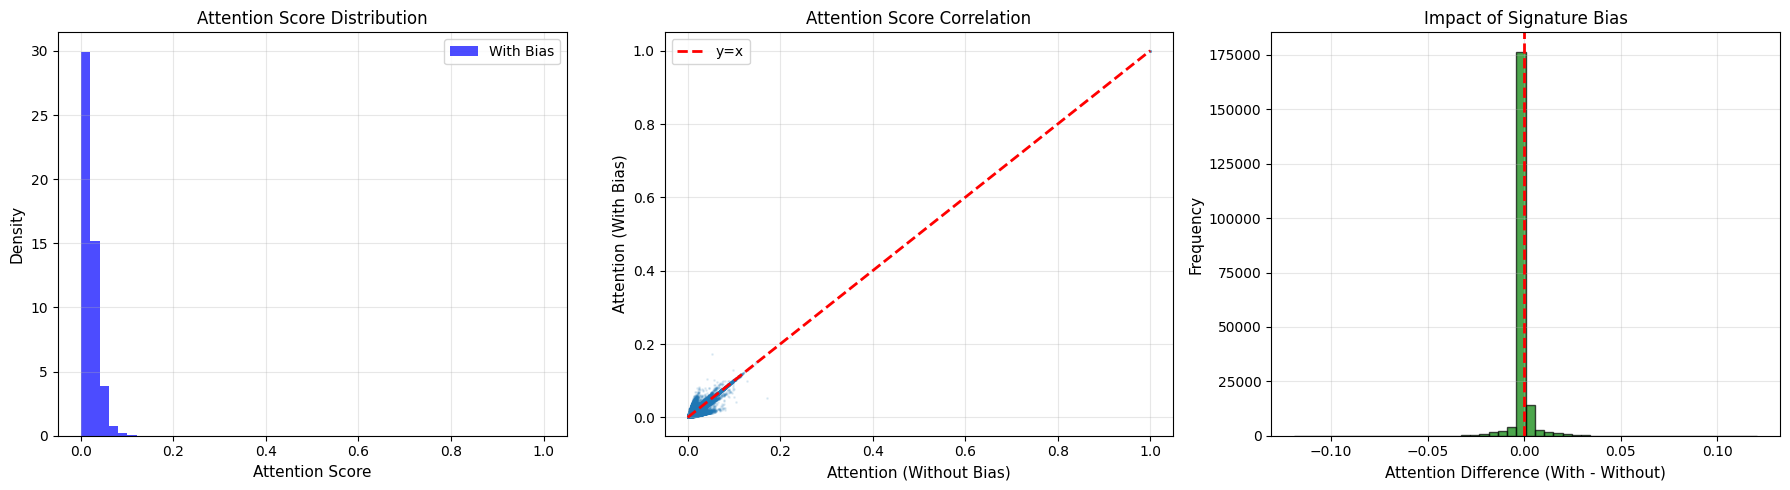


✓ Attention scores compared successfully!
  Total edges compared: 207071


In [48]:
# Compare attention scores between models with and without signature bias

import gzip
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load attention scores
attention_with_bias_file = 'embedding_data/V1_Human_Lymph_Node_spatial/SigRelayST_with_bias_r1_attention'
attention_no_bias_file = 'embedding_data/V1_Human_Lymph_Node_spatial_no_bias/SigRelayST_no_bias_r1_attention'

try:
    # Load attention scores
    with gzip.open(attention_with_bias_file, 'rb') as f:
        attention_with_bias = pickle.load(f)

    with gzip.open(attention_no_bias_file, 'rb') as f:
        attention_no_bias = pickle.load(f)

    # Extract attention values
    # attention format: [edge_indices, attention_scores, ...]
    att_with = attention_with_bias[1] if len(attention_with_bias) > 1 else None
    att_no = attention_no_bias[1] if len(attention_no_bias) > 1 else None

    if att_with is not None and att_no is not None:
        # Flatten attention scores for comparison
        att_with_flat = np.array(att_with).flatten()
        att_no_flat = np.array(att_no).flatten()

        # Statistics
        print("=" * 60)
        print("Attention Score Comparison")
        print("=" * 60)
        print(f"With bias:")
        print(f"  Mean: {np.mean(att_with_flat):.6f}")
        print(f"  Std:  {np.std(att_with_flat):.6f}")
        print(f"  Min:  {np.min(att_with_flat):.6f}")
        print(f"  Max:  {np.max(att_with_flat):.6f}")
        print(f"\nWithout bias:")
        print(f"  Mean: {np.mean(att_no_flat):.6f}")
        print(f"  Std:  {np.std(att_no_flat):.6f}")
        print(f"  Min:  {np.min(att_no_flat):.6f}")
        print(f"  Max:  {np.max(att_no_flat):.6f}")
        print(f"\nDifference (with - without):")
        print(f"  Mean diff: {np.mean(att_with_flat) - np.mean(att_no_flat):.6f}")

        # Plot comparison
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Histogram comparison
        axes[0].hist(att_with_flat, bins=50, alpha=0.7, label='With Bias', color='blue', density=True)
        #axes[0].hist(att_no_flat, bins=50, alpha=0.7, label='Without Bias', color='red', density=True)
        axes[0].set_xlabel('Attention Score', fontsize=11)
        axes[0].set_ylabel('Density', fontsize=11)
        axes[0].set_title('Attention Score Distribution', fontsize=12)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Scatter plot
        min_len = min(len(att_with_flat), len(att_no_flat))
        axes[1].scatter(att_no_flat[:min_len], att_with_flat[:min_len], alpha=0.1, s=1)
        axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='y=x')
        axes[1].set_xlabel('Attention (Without Bias)', fontsize=11)
        axes[1].set_ylabel('Attention (With Bias)', fontsize=11)
        axes[1].set_title('Attention Score Correlation', fontsize=12)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # Difference distribution
        diff = att_with_flat[:min_len] - att_no_flat[:min_len]
        axes[2].hist(diff, bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[2].axvline(0, color='red', linestyle='--', linewidth=2)
        axes[2].set_xlabel('Attention Difference (With - Without)', fontsize=11)
        axes[2].set_ylabel('Frequency', fontsize=11)
        axes[2].set_title('Impact of Signature Bias', fontsize=12)
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"\n✓ Attention scores compared successfully!")
        print(f"  Total edges compared: {min_len}")

    else:
        print("Could not extract attention scores from loaded data.")
        print(f"Attention with bias structure: {type(attention_with_bias)}, length: {len(attention_with_bias) if hasattr(attention_with_bias, '__len__') else 'N/A'}")
        print(f"Attention no bias structure: {type(attention_no_bias)}, length: {len(attention_no_bias) if hasattr(attention_no_bias, '__len__') else 'N/A'}")

except FileNotFoundError as e:
    print(f"Attention file not found: {e}")
    print("Please ensure both models have completed training.")
except Exception as e:
    print(f"Error comparing attention scores: {e}")
    import traceback
    traceback.print_exc()


## Step 5: Postprocess and Compare Results

Postprocess both models to generate communication lists and compare top-ranked communications.


In [47]:
# Postprocess model WITH signature bias

import subprocess

print("=" * 60)
print("Postprocessing Model WITH Signature Bias")
print("=" * 60)

result = subprocess.run([
    'python', 'output_postprocess_SigRelayST.py',
    '--data_name=V1_Human_Lymph_Node_spatial',
    '--model_name=SigRelayST_with_bias',
    '--total_runs=1'
], capture_output=False, text=True)

if result.returncode == 0:
    print("\n✓ Postprocessing WITH signature bias completed!")
    print("  Results: output/V1_Human_Lymph_Node_spatial/SigRelayST_with_bias_top20percent.csv")
else:
    print(f"\n✗ Postprocessing failed with return code {result.returncode}")


Postprocessing Model WITH Signature Bias

✗ Postprocessing failed with return code 1


In [45]:
# Postprocess model WITHOUT signature bias

import subprocess

print("=" * 60)
print("Postprocessing Model WITHOUT Signature Bias")
print("=" * 60)

result = subprocess.run([
    'python', 'output_postprocess_SigRelayST.py',
    '--data_name=V1_Human_Lymph_Node_spatial_no_bias',
    '--model_name=SigRelayST_no_bias',
    '--total_runs=1'
], capture_output=False, text=True)

if result.returncode == 0:
    print("\n✓ Postprocessing WITHOUT signature bias completed!")
    print("  Results: output/V1_Human_Lymph_Node_spatial_no_bias/SigRelayST_no_bias_top20percent.csv")
else:
    print(f"\n✗ Postprocessing failed with return code {result.returncode}")


Postprocessing Model WITHOUT Signature Bias

✗ Postprocessing failed with return code 1


In [46]:
# Compare top-ranked communications between models

import pandas as pd
import numpy as np

top_with_file = 'output/V1_Human_Lymph_Node_spatial/SigRelayST_with_bias_top20percent.csv'
top_no_file = 'output/V1_Human_Lymph_Node_spatial_no_bias/SigRelayST_no_bias_top20percent.csv'

try:
    # Load top communications
    df_with = pd.read_csv(top_with_file, header=None)
    df_no = pd.read_csv(top_no_file, header=None)

    # Assuming format: cell_i, cell_j, ligand, receptor, attention_score
    if df_with.shape[1] >= 5:
        df_with.columns = ['cell_i', 'cell_j', 'ligand', 'receptor', 'attention'] + [f'col_{i}' for i in range(5, df_with.shape[1])]
        df_no.columns = ['cell_i', 'cell_j', 'ligand', 'receptor', 'attention'] + [f'col_{i}' for i in range(5, df_no.shape[1])]

        # Create LR pair identifiers
        df_with['lr_pair'] = df_with['ligand'].astype(str) + '-' + df_with['receptor'].astype(str)
        df_no['lr_pair'] = df_no['ligand'].astype(str) + '-' + df_no['receptor'].astype(str)

        # Find common and unique LR pairs
        lr_with = set(df_with['lr_pair'].unique())
        lr_no = set(df_no['lr_pair'].unique())

        common_lr = lr_with.intersection(lr_no)
        unique_with = lr_with - lr_no
        unique_no = lr_no - lr_with

        print("=" * 60)
        print("Top-Ranked Communications Comparison")
        print("=" * 60)
        print(f"Total communications (with bias): {len(df_with)}")
        print(f"Total communications (without bias): {len(df_no)}")
        print(f"\nCommon LR pairs in top 20%: {len(common_lr)}")
        print(f"Unique to WITH bias: {len(unique_with)}")
        print(f"Unique to WITHOUT bias: {len(unique_no)}")
        print(f"\nOverlap: {len(common_lr) / max(len(lr_with), len(lr_no)) * 100:.1f}%")

        # Show top unique pairs
        if len(unique_with) > 0:
            print(f"\nTop 10 LR pairs unique to WITH bias:")
            unique_with_df = df_with[df_with['lr_pair'].isin(unique_with)].nlargest(10, 'attention')
            for idx, row in unique_with_df.iterrows():
                print(f"  {row['lr_pair']}: {row['attention']:.6f}")

        if len(unique_no) > 0:
            print(f"\nTop 10 LR pairs unique to WITHOUT bias:")
            unique_no_df = df_no[df_no['lr_pair'].isin(unique_no)].nlargest(10, 'attention')
            for idx, row in unique_no_df.iterrows():
                print(f"  {row['lr_pair']}: {row['attention']:.6f}")

        print("\n✓ Comparison completed!")

    else:
        print("Unexpected CSV format. Columns:", df_with.shape[1])
        print("First few rows:")
        print(df_with.head())

except FileNotFoundError as e:
    print(f"Results file not found: {e}")
    print("Please ensure postprocessing has completed for both models.")
except Exception as e:
    print(f"Error comparing results: {e}")
    import traceback
    traceback.print_exc()


Results file not found: [Errno 2] No such file or directory: 'output/V1_Human_Lymph_Node_spatial/SigRelayST_with_bias_top20percent.csv'
Please ensure postprocessing has completed for both models.
